In [1]:
from preprocessing import apply_OHE, init_OHE, init_dataset, eliminar_features, reduce_by_frequency

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import auxiliar as aux

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

<h1>Random Forest</h1>

Los hiperparámetros que consideramos relevantes para el Modelo Random Forest:
   - criterion: La funcion para medir la calidad de una particion.
   - max_depth: Profundidad maxima de los arboles.
   - min_samples_leaf: El numero mínimo de muestras requerido para que un nodo sea considerado como nodo hoja. 
   - n_estimators: El número de árboles en el ensamble

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categóricos:

<h3> Preprocesamiento 1: OHE</h3> 

Primero vamos a entrenar el random forest aplicando unicamente OHE a las columnas categoricas:

In [2]:
X, y = aux.get_train_set()
X = init_dataset(X)

In [3]:
init_OHE(X)
X_p1 = apply_OHE(X)

Partimos nuestro set en train y validation, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [4]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p1, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para el Random Forest con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El criterio se definió como entropia ya que siempres se obtenia este resultado mientras se hacian variar los demas hiperparametros.
    - El número de estimadores óptimo para las metricas que se calculan siempre estuvo entre 200 y 300, por lo se limitan las opciones a esos valores.

In [5]:
parameters = {'criterion': ['entropy'], 'max_depth': np.arange(15, 21, 1), 'min_samples_leaf': np.arange(50, 101, 50), 'n_estimators': np.arange(200, 401, 100)}

clf = RandomForestClassifier(random_state = 0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True
).fit(X_train, y_train)

In [6]:
print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.9073768721451376
Mejores Parametros {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 50, 'n_estimators': 300}

Mejor score ROC-AUC en Validación: 0.9012194083902519


In [7]:
random_forest_p1 = gscv.best_estimator_
random_forest_p1

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=50,
                       n_estimators=300, random_state=0)

Predecimos con el validation set:

In [8]:
y_pred_p1 = random_forest_p1.predict(X_validation)

### Métricas

In [9]:
print(classification_report(y_validation, y_pred_p1))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      4945
           1       0.78      0.49      0.60      1568

    accuracy                           0.84      6513
   macro avg       0.82      0.72      0.75      6513
weighted avg       0.84      0.84      0.83      6513



Mostramos la matriz de confusión:

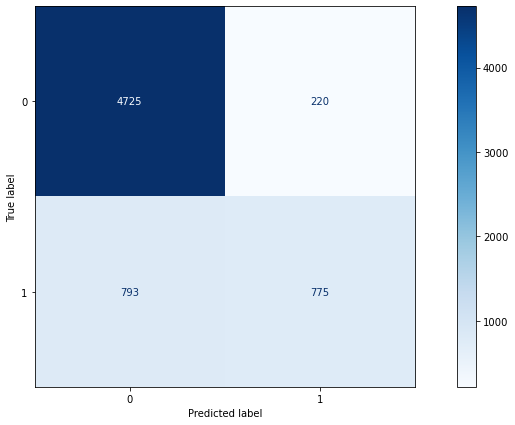

In [10]:
aux.plot_cm(random_forest_p1, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

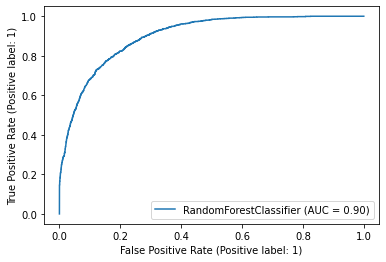

In [11]:
plot_roc_curve(random_forest_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h3> Preprocesamiento 2: OHE y Reducción de las columnas: Barrio, Religion, Categoria de Trabajo, Estado Marital </h3>

A diferencia del preprocesado anterior, ahora reduciremos por frecuencia de aparición algunas columnas dejando solo las categorias que tengan más del 15% de los datos y agrupando en una misma las demás. Luego aplicaremos OHE a las columnas categóricas. Al realizar este primer preproceso obtenemos una reduccion dimensional cuando apliquemos OHE. Las columnas que reduciremos son: 'Barrio', 'Religión', 'Categoría de Trabajo' y 'Estado Marital', que son features con categorias con muy pocos datos según lo analizado en el TP1

In [12]:
X_p2 = reduce_by_frequency(X, ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital'], 0.15)

In [13]:
init_OHE(X_p2)
X_p2 = apply_OHE(X_p2)

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p2, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para el Random Forest con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El criterio se definió como entropia ya que siempres se obtenia este resultado mientras se hacian variar los demas hiperparametros.
    - El número de estimadores óptimo para las metricas que se calculan siempre estuvo entre 200 y 300, por lo se limitan las opciones a esos valores.

In [15]:
parameters = {'criterion': ['entropy'], 'max_depth': np.arange(15, 21, 1), 'min_samples_leaf': np.arange(50, 101, 50), 'n_estimators': np.arange(200, 401, 100)}

clf = RandomForestClassifier(random_state = 0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [16]:
print(f"Mejor score ROC-AUC: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC: 0.9107417085951426
Mejores Parametros {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 50, 'n_estimators': 400}

Mejor score ROC-AUC en Validación: 0.9058621236664535


Armamos el modelo de random forest con los hiperparametros calculados:

In [17]:
random_forest_p2 = gscv.best_estimator_
random_forest_p2

RandomForestClassifier(criterion='entropy', max_depth=18, min_samples_leaf=50,
                       n_estimators=400, random_state=0)

Predecimos con el validation set:

In [18]:
y_pred_p2 = random_forest_p2.predict(X_validation)

### Métricas

In [19]:
print(classification_report(y_validation, y_pred_p2))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4945
           1       0.78      0.52      0.62      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.76      6513
weighted avg       0.84      0.85      0.84      6513



Mostramos la matriz de confusión:

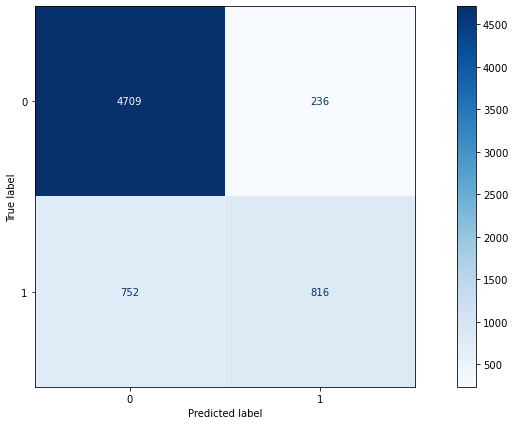

In [20]:
aux.plot_cm(random_forest_p2, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

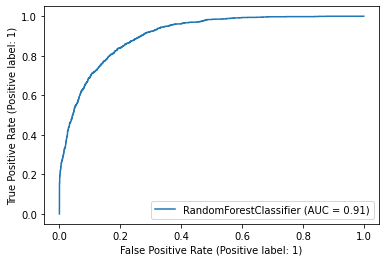

In [21]:
plot_roc_curve(random_forest_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h3> Preprocesamiento 3: Eliminación de Columnas + Reducción por Frecuencia </h3>

En este preprocesamiento eliminamos las columnas 'religion', 'barrio' y 'categoria de trabajo' ya que en el análisis del TP1 concluimos que no aportaban demasiada información. Además agrupamos las categorias que contienen menos del 5% de los datos, y finalmente aplicamos One Hot Encoding

In [22]:
X_p3 = eliminar_features(X, ['religion', 'barrio', 'categoria_de_trabajo'])
X_p3 = reduce_by_frequency(X_p3, ['estado_marital', 'trabajo'], 0.05)

In [23]:
init_OHE(X_p3)
X_p3 = apply_OHE(X_p3)

In [24]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_p3, y, random_state=0, test_size=0.2, stratify=y
)

Buscamos los mejores hiperparametros para el Random Forest con GridSearchCV:

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - El intervalo de min_samples_leaf tiene un paso de 50 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El intervalo de max_depth tiene un paso de 5 valores ya que consideramos que una diferencia menor a este valor resulta ser irrelevante para las metricas que se calculan.
    - El criterio se definió como entropia ya que siempres se obtenia este resultado mientras se hacian variar los demas hiperparametros.
    - El número de estimadores óptimo para las metricas que se calculan siempre estuvo entre 200 y 300, por lo se limitan las opciones a esos valores.

In [25]:
parameters = {'criterion': ['entropy'], 'max_depth': np.arange(15, 21, 1), 'min_samples_leaf': np.arange(50, 101, 50), 'n_estimators': np.arange(200, 401, 100),
              'class_weight': [None, 'balanced']}

clf = RandomForestClassifier(random_state = 0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [26]:
print(f"Mejor score ROC-AUC: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC: 0.9086427213476057
Mejores Parametros {'class_weight': None, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 50, 'n_estimators': 300}

Mejor score ROC-AUC en Validación: 0.9044381048678319


Armamos el modelo de random forest con los hiperparametros calculados:

In [27]:
random_forest_p3 = gscv.best_estimator_
random_forest_p3

RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=50,
                       n_estimators=300, random_state=0)

Predecimos con el validation set:

In [28]:
y_pred_p3 = random_forest_p3.predict(X_validation)

### Métricas

In [29]:
print(classification_report(y_validation, y_pred_p3))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4945
           1       0.78      0.52      0.62      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.76      6513
weighted avg       0.84      0.85      0.84      6513



Mostramos la matriz de confusión:

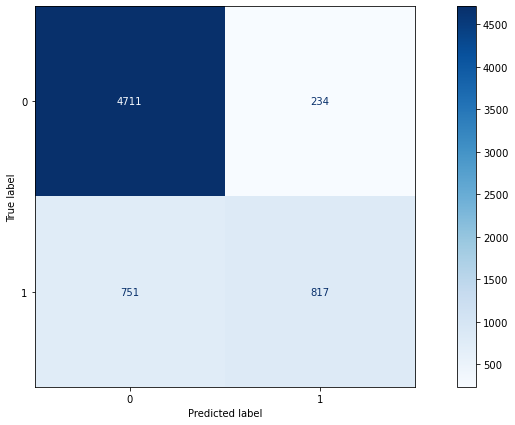

In [30]:
aux.plot_cm(random_forest_p3, X_validation, y_validation)

Mostramos el gráfico de la curva roc:

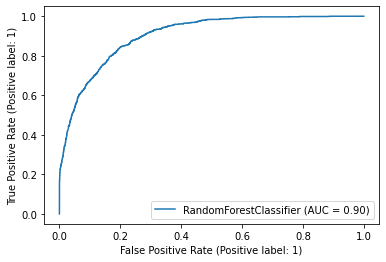

In [31]:
plot_roc_curve(random_forest_p3, X_validation, y_validation, response_method="predict_proba")
plt.show()

<h1>Conclusión</h1>

Al aplicar el segundo preprocesamiento obtenemos una mejora de performance: Aumenta la cantidad de casos con alto valor adquisitivo que predice correctamente, aunque los casos sin alto valor adquisitivo predecidos correctamente disminuye.
Si bien no hay mucha diferencia entre el preprocesamiento 1 y el preprocesamiento 2, en el segundo hay una leve mejora. Entonces nos quedaremos con el segundo modelo. A continuación se ve como ejemplo uno de los arboles del random forest:

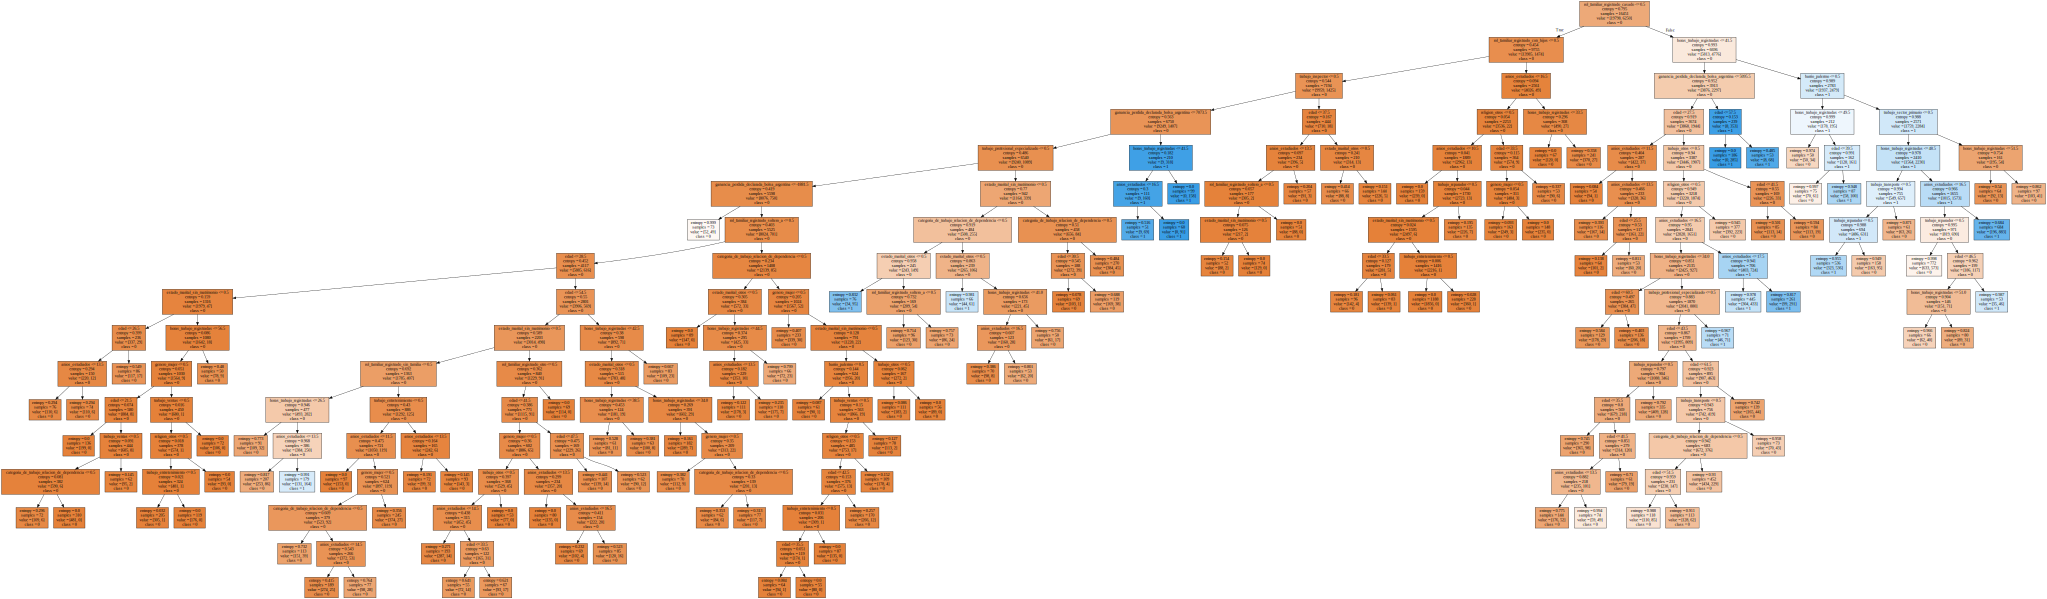

In [32]:
aux.plot_tree(random_forest_p2.estimators_[0], X_p2.columns)

<h1>Predicción</h1>

In [33]:
ids, X_holdout = aux.get_holdout_set()

In [34]:
X_holdout = init_dataset(X_holdout)

In [35]:
X_holdout_p2 = reduce_by_frequency(X_holdout, ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital'], 0.15)
X_holdout_p2 = apply_OHE(X_holdout_p2)

ValueError: The number of features in X is different to the number of features of the fitted data. The fitted data had 4 features and the X has 7 features.

In [ ]:
random_forest_pred = random_forest_p2.predict(X_holdout_p2)

In [ ]:
aux.create_prediction(ids, random_forest_pred, file_name='random_forest')